In [133]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader
from albumentations import (
    Compose, OneOf,
    HorizontalFlip, VerticalFlip, Flip, Rotate,
    Blur, GaussNoise, MedianBlur, MotionBlur, 
    HueSaturationValue, InvertImg, RandomBrightness,
    RandomBrightnessContrast, RandomContrast, RandomGamma,
    RGBShift, ToGray, CLAHE, Transpose, ChannelShuffle

)
from albumentations.pytorch import ToTensor
import cv2
import glob
import numpy as np

# Digits class is a preproccening class for a dataset

In [153]:
class digits(object):
    def __init__(self, train_set):
        self.train_set = train_set
        self.dic = {}
        for i in range(10):
            self.dic[i] = np.where(self.train_set.targets.numpy() == i)[0]
    
    def get_ingredients(self, num):
        '''The function check if number needed to add zeros for get uniform shape of persention '''
        if(num <= 100):
            if num < 10:
                str_num = '00' + str(num)
            if num > 9 and num < 100 :
                str_num = '0' + str(num)
            if num == 100:
                str_num = str(num)
        return [int(d) for d in str_num]


    def generate_full_dictionary(self, amount=6000):
        '''The function generate random numbers from the basic dictionary. 
            For lower computational the function save indexes and won't acutally create images'''
        full_dic={}
        for i in range(101):
            temp = []
            for j in range(amount):
                l = self.get_ingredients(i)
                digit1, digit2, digit3 = l[:3]
                index1 = np.random.choice(self.dic.get(digit1))
                index2 = np.random.choice(self.dic.get(digit2))
                index3 = np.random.choice(self.dic.get(digit3))
                temp.append([index1, index2, index3])

            full_dic[i] = temp

        return full_dic
      
    def generate_image(self, images_indexes_list): 
        '''The function create image'''
        l = [self.train_set.data.numpy()[int(index)] for index in images_indexes_list ]
        return cv2.hconcat(l)
    
    def split_train_test(self, full_dictionary, test_split=False, p=1):
        
        raw_data = []
        for index, imgs_list in full_dictionary.items():
            for img in imgs_list:
                raw_data.append((img, index))
        
        raw_data = np.asarray(raw_data)
        np.random.shuffle(raw_data)

        if test_split:
            barrier = int(np.round(len(raw_data) * (1- p)))
            train, test = raw_data[:barrier], raw_data[barrier:]
            train_x, train_y = train[:, 0], train[:, 1]
            test_x, test_y = test[:, 0], test[:, 1]
            return train_x, train_y, test_x, test_y

            
        return raw_data[:, 0], raw_data[:, 1]

#  MNISTDataset is a class that handles with a model data

In [135]:
class MNISTDataset(Dataset):
    def __init__(self, digits, transforms=None):
        super(MNISTDataset, self).__init__()
        self.all_digits = digits
        f = digits.generate_full_dictionary()
        self.x_train, self.y_train = self.all_digits.split_train_test(f)
        self.transform = transforms

    def __getitem__(self, idx):
        x = self.x_train[idx]
        y = self.y_train[idx]
        if self.transform:
            x = self.transform(image=self.all_digits.generate_image(x))
            x = x['image']
        return x, y
    
    def __len__(self):
        return len(self.x_train)


In [136]:
def get_train_set():
    return torchvision.datasets.MNIST(root='', train=True, download=True)

def create_digits_object(train_set):
    return digits(train_set)

def set_transforms(p=1):
    return Compose([OneOf([
                            Blur(blur_limit=7),
                            GaussNoise(var_limit=(10,50)),
                            MedianBlur(blur_limit=7),
                            MotionBlur(blur_limit=7), 
                    ]),
                    OneOf([
                           InvertImg(),
                           RandomBrightness(limit=1),
                           RandomBrightnessContrast(brightness_limit=1, contrast_limit=1),
                           RandomContrast(limit=1),
                           RandomGamma(gamma_limit=(80, 120))
                    ]),
                    Rotate(
                        limit=(-20, 20),
                        interpolation=cv2.INTER_CUBIC,
                        border_mode=cv2.BORDER_REPLICATE)],
                p=p)
    
def create_dataset(digits, transforms=None):
    return MNISTDataset(
                            digits,
                             transforms=transforms
                             )

    
def show_all(images, labels):
    plt.figure(figsize=(20, 10))
    lenght = len(images)
    for i in range(lenght):
        plt.subplot(1, lenght, i+1)
        plt.imshow(images[i], cmap='gray')
        plt.title(f'label = {labels[i]}', fontsize=20)
    plt.show()




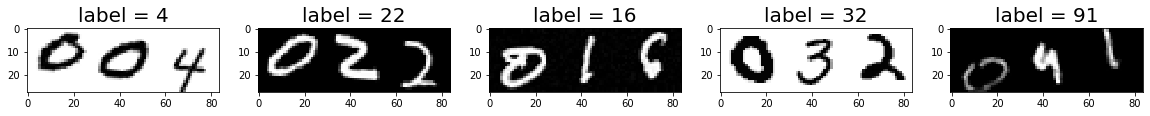

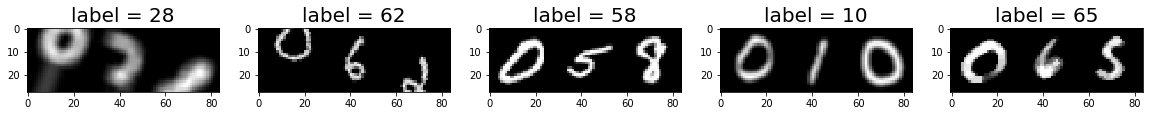

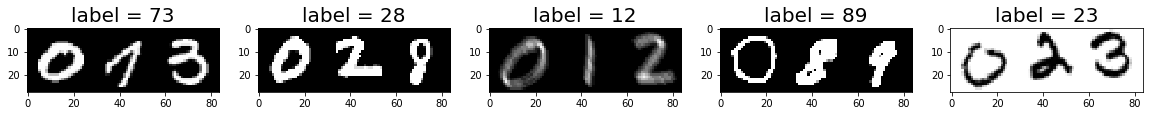

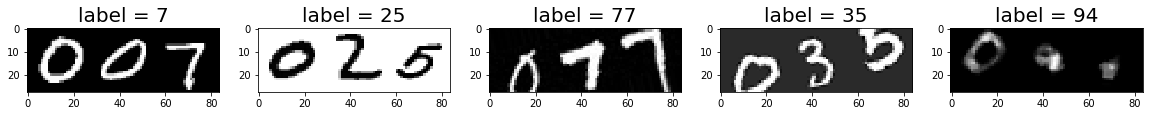

In [155]:
train_set = get_train_set()
digs = create_digits_object(train_set)
mnist_transform = set_transforms()
mnist_dataset = create_dataset(digs, mnist_transform)

BS = 5
mnist_dataloader = DataLoader(mnist_dataset, batch_size=BS, shuffle=True)
for i in range(4):
    next_batch = iter(mnist_dataloader)
    imgs, labels = next(next_batch)
    show_all(imgs, labels)


# d) Load images and masks from Kaggle
## Aerial Semantic Segmentation Drone Dataset 

In [121]:
def read_images_and_masks():
    """
    The mathod get all the paths of an image and her corresponding mask, 
    save it in two lists and return them.
    """
    
    original_path = 'C:\\Users\\yoav_\\Downloads\\cv\\seg\\original\\*.jpg'
    mask_path = 'C:\\Users\\yoav_\\Downloads\\cv\\seg\\segmentation\\*.png'

    paths = [
        original_path,
        mask_path]

    original_imgs = []
    masks_imgs = []
    for path in paths:
        for img in glob.glob(path):
            if 'original' in path:
                original_imgs.append(img)
            else:
                masks_imgs.append(img)
                
    return original_imgs, masks_imgs



def set_transform(p=1):
    return Compose([
                    OneOf([
                        HorizontalFlip(),
                        VerticalFlip(),
                        Flip(),
                        Rotate(limit=(-360, 360),
                               interpolation=cv2.INTER_CUBIC,
                                border_mode=cv2.BORDER_REPLICATE)
                    ]), 
                    OneOf([
                            Blur(blur_limit=500),
                            GaussNoise(var_limit=(10,50)),
                            MedianBlur(blur_limit=7),
                            MotionBlur(blur_limit=7), 
                    ]),
                    OneOf([
                           HueSaturationValue(hue_shift_limit=20, sat_shift_limit=50, val_shift_limit=50),
                           RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20),
                           ChannelShuffle(),
                           ToGray()
                    ]),
                    OneOf([
                           InvertImg(),
                           RandomBrightness(limit=0.2),
                           RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2),
                           RandomContrast(),
                           RandomGamma(gamma_limit=(80, 120)),
                           CLAHE(clip_limit=4.0),
                           Transpose()

                    ])], p=p
            )

def show_all(images, masks):
    """The method plot pair of image and mask"""
    plt.figure(figsize=(20, 10))
    length = len(images)
    counter=1
    for img,mask in zip(images,masks):
        plt.subplot(length,2,counter)
        plt.imshow(img)
        plt.subplot(length,2,counter+1)
        plt.imshow(mask, cmap='gray')
        counter+=2

    plt.show()


def create_dataset(originals, masks, transforms=None):
    return Mdataset(originals, masks, transforms=transforms)

# Mdataset - The class that handles with the dataset 

In [122]:
class Mdataset(Dataset):
    def __init__(self, originals, masks, transforms=None):
        super(Mdataset, self).__init__()
        self.image_paths = originals
        self.mask_paths = masks
        self.transform = transforms


    def __getitem__(self, idx):
        img = plt.imread(self.image_paths[idx])
        mask = plt.imread(self.mask_paths[idx])
        
        if self.transform:
            aug = self.transform(image=img, mask=mask)
            img = np.asarray(aug['image'])
            mask = np.asarray(aug['mask'])
        
        return torch.from_numpy(img), torch.from_numpy(mask)

    def __len__(self):
        return len(self.image_paths)


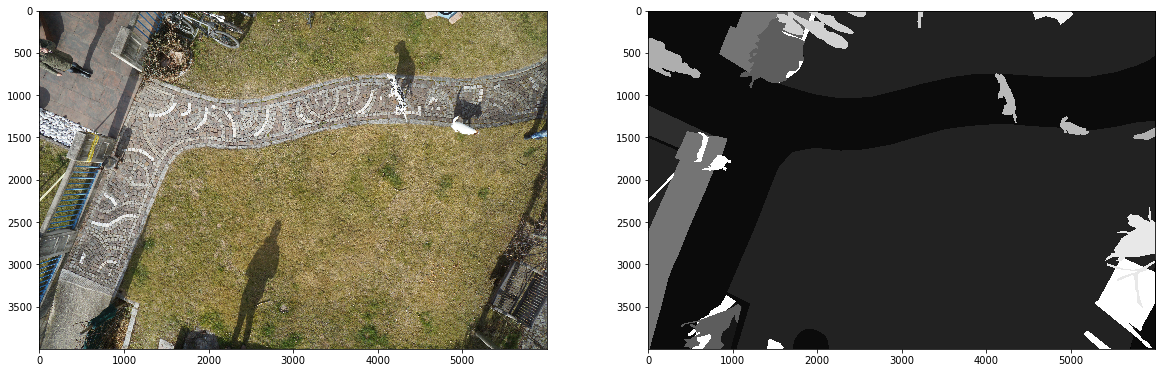

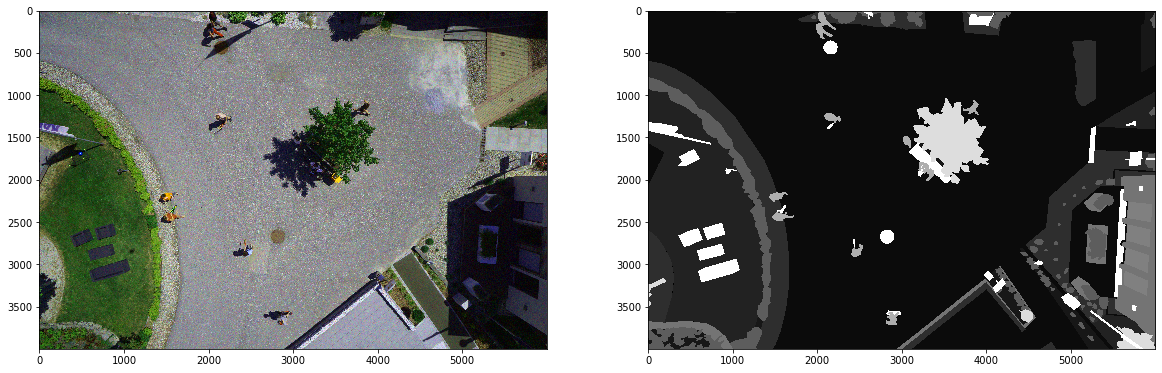

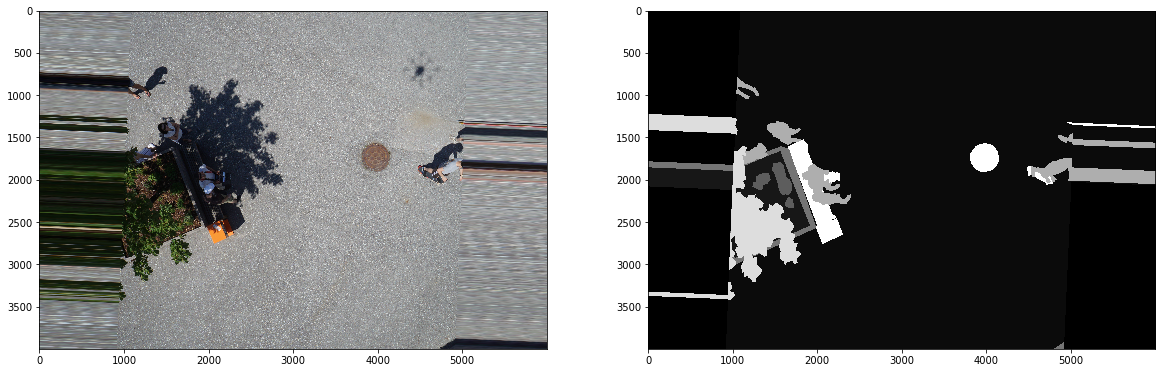

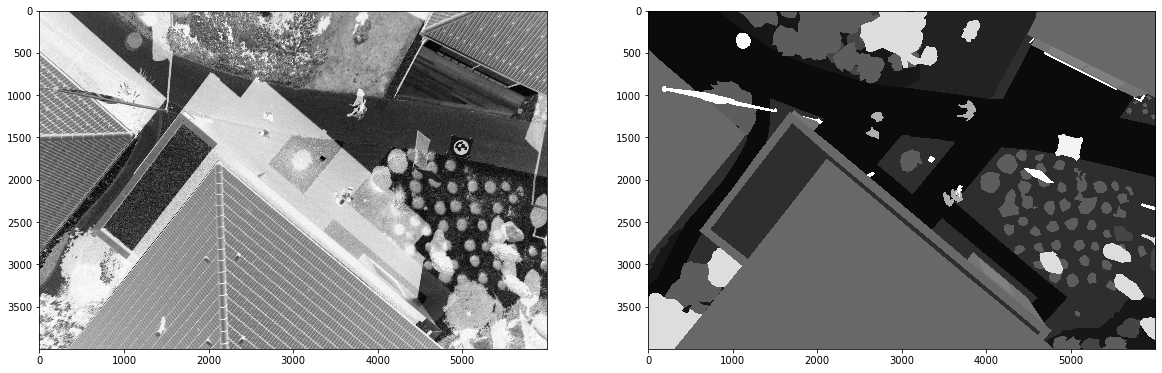

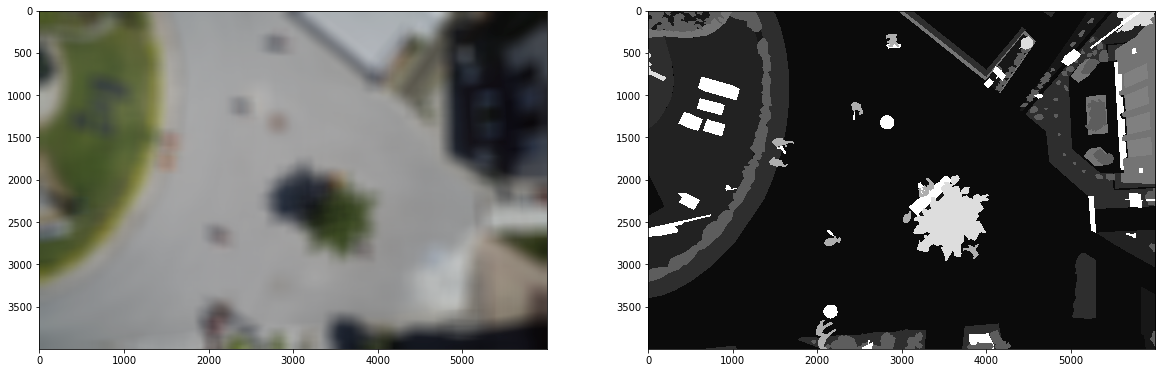

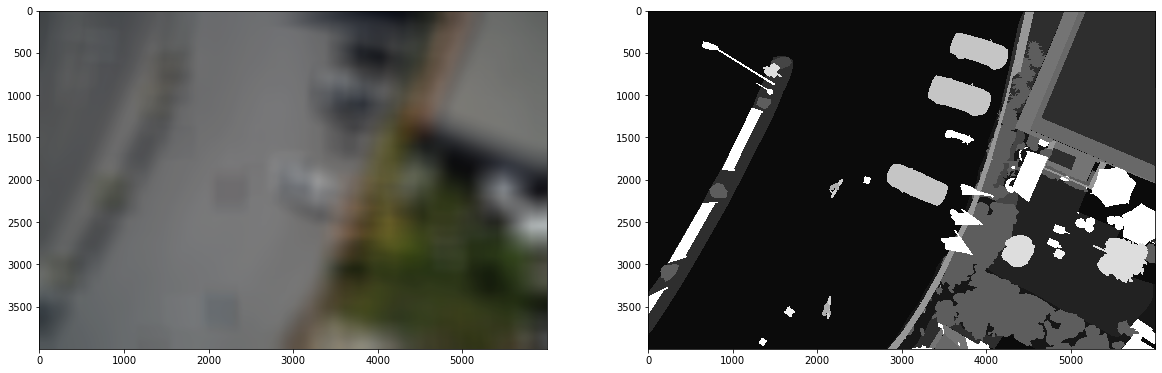

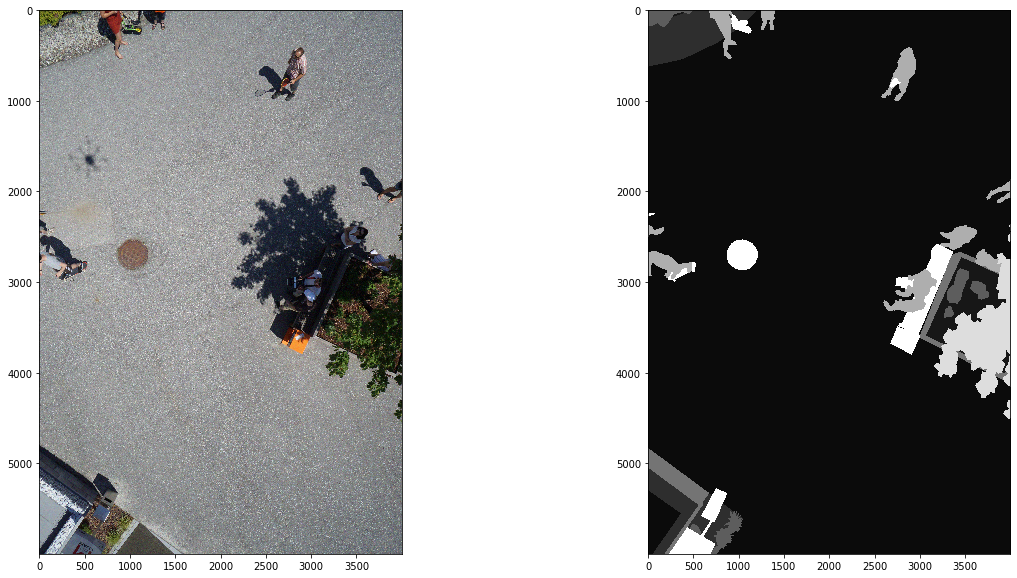

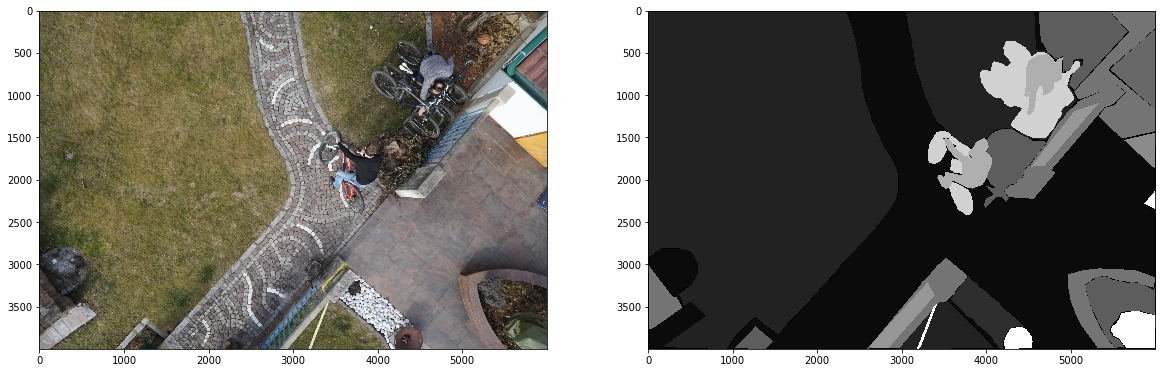

In [123]:
original_imgs, masks_imgs = read_images_and_masks()
img_transforms = set_transform()
img_dataset = create_dataset(original_imgs, masks_imgs, img_transforms)

BS = 1
img_dataloader = DataLoader(img_dataset, batch_size=BS, shuffle=True)
for i in range(8):
    next_batch = iter(img_dataloader)
    imgs, labels = next(next_batch)
    show_all(imgs,labels)
